# Downloading the MovieLens data

Please view the [MovieLens liense](http://files.grouplens.org/datasets/movielens/ml-10m-README.html) before downloading the dataset and continuing with this datalab. 

First, we will download the data into the same folder as this notebook. 

In [3]:
%%bash
if [ ! -f "ml-10m.zip" ]
then
  wget "http://files.grouplens.org/datasets/movielens/ml-10m.zip"
fi

converted 'http://files.grouplens.org/datasets/movielens/ml-10m.zip' (ANSI_X3.4-1968) -> 'http://files.grouplens.org/datasets/movielens/ml-10m.zip' (UTF-8)
--2016-08-30 16:41:54--  http://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.146
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: 'ml-10m.zip'

     0K .......... .......... .......... .......... ..........  0%  589K 1m49s
    50K .......... .......... .......... .......... ..........  0% 1.15M 81s
   100K .......... .......... .......... .......... ..........  0% 99.7M 54s
   150K .......... .......... .......... .......... ..........  0%  125M 41s
   200K .......... .......... .......... .......... ..........  0% 1.15M 44s
   250K .......... .......... .......... .......... ..........  0%  134M 36s
   300K .......... .......

Next we unzip the file.

In [4]:
!rm -fr ml-10M100K
!unzip ml-10m.zip

Archive:  ml-10m.zip
   creating: ml-10M100K/
  inflating: ml-10M100K/allbut.pl    
  inflating: ml-10M100K/movies.dat   
  inflating: ml-10M100K/ratings.dat  
  inflating: ml-10M100K/README.html  
  inflating: ml-10M100K/split_ratings.sh  
  inflating: ml-10M100K/tags.dat     


The [README](ml-10M100K/README.html) file contains a description of each file and the file format used. We will build a model using ratings.dat.


# Yearly usage of Movielens

As the dataset is small enough, we will just read everything into pandas. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The next read statement could take a few minutes.

In [6]:
raw = pd.read_csv('ml-10M100K/ratings.dat', sep='::', header=None, names=['userid', 'movieid', 'rating', 'timestamp'], engine='python')


In [7]:
raw['rating'].describe()

count    1.000005e+07
mean     3.512422e+00
std      1.060418e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Note that the minimum rating in the dataset is not "zero" stars, but "0.5" stars. Also, the average rating is 3.5 stars. 

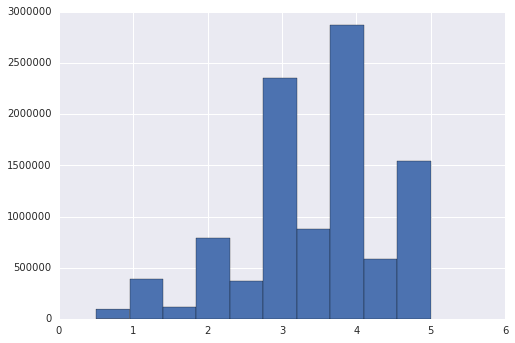

In [8]:
_ = raw['rating'].hist()

There is a clear bias for whole number ratings.

In [9]:
date = pd.to_datetime(raw['timestamp'].values, unit='s')
year_count = np.bincount(date.year)
years = np.nonzero(year_count)[0]
zip(years, year_count[years]) 

[(1995, 3),
 (1996, 1047618),
 (1997, 459947),
 (1998, 202092),
 (1999, 788793),
 (2000, 1271623),
 (2001, 759141),
 (2002, 583409),
 (2003, 688694),
 (2004, 768168),
 (2005, 1177283),
 (2006, 765733),
 (2007, 699325),
 (2008, 773617),
 (2009, 14608)]

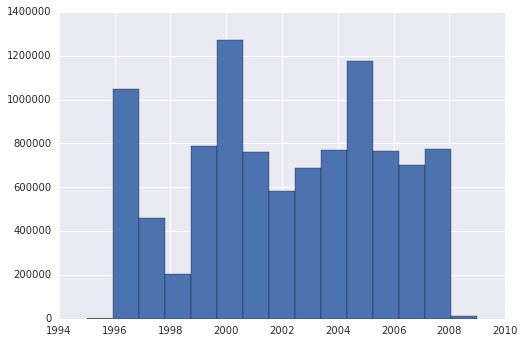

In [10]:
_ = plt.hist(date.year, bins=15)


In certain years, the Movielens tool was used more heavily.

# User activity

In [11]:
user_histo = raw['userid'].value_counts()
user_histo

59269    7359
67385    7047
14463    5169
68259    4483
27468    4449
19635    4165
3817     4165
63134    3755
58357    3697
27584    3479
6757     3414
56707    3225
19379    3202
7795     3187
8811     3164
30723    3027
30687    2909
31327    2886
30500    2827
47046    2812
42791    2806
47345    2801
62332    2766
14134    2753
57126    2697
30158    2644
51033    2634
59659    2608
59598    2601
38928    2555
         ... 
43274      20
35086      20
31005      20
23070      20
35121      20
12498      20
26259      20
62072      20
30702      20
22252      20
20703      20
33895      20
16285      20
62073      20
56372      20
66774      20
1416       20
11672      20
29967      20
54555      20
52215      20
70486      20
61121      20
27619      20
62317      20
41151      20
15833      20
10531      20
43559      20
12546      20
Name: userid, dtype: int64

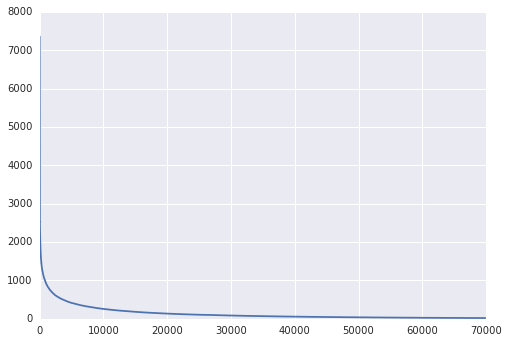

In [12]:
_ = plt.plot(user_histo.values) # y-axis=number of ratings by a user, x-axis=index of array (junk)


This last plot shows our first problem with the Movielens dataset: there are a few users who have an incredibly high number of ratings. Did user 59269 really watch and rate 7359 movies, or could there be something odd about user 59269? For example, maybe user 59269 is a robot. Also, every user in the dataset rated at least 20 movies. 

Looking at the plot, it looks like most users rated less than 500 movies. Lets look at who rated more than 500 movies.

In [13]:
num_power_users = sum(user_histo.values > 500)
num_total_users = user_histo.shape[0]
print '%d/%d = %f%% are power users' % (num_power_users, num_total_users, 100*num_power_users/float(num_total_users))


3659/69878 = 5.236269% are power users


In [14]:
num_ratings_by_power_users = sum(user_histo[user_histo.values > 500])
num_total_ratings = raw.shape[0]
print '%d/%d = %f%% of ratings are by power users!' % (num_ratings_by_power_users, num_total_ratings, 100*num_ratings_by_power_users/float(num_total_ratings))

3102710/10000054 = 31.026932% of ratings are by power users!


This is interesting. About 5% of all users account for 31% of the data! This could be an issue. If we build a model without this fact in mind, the model could place all its energy on giving very good predictions to 5% of users. Another way of looking at this is that maybe we should only care about about the prediction quality of the top users as they are the ones who are really using the service. In either case, we have to make a decision on what to do with the power users. For example, when training a model, we could keep all the ratings from power users, delete all their ratings, only keep the 500 most recent ratings, sample from their ratings list, etc. In this datalab we will keep it simple and and treat these power users as "spammers" and delete their existence from the data. Of course, in a real recommendation system, these special users have to be processed in a smarter way. 

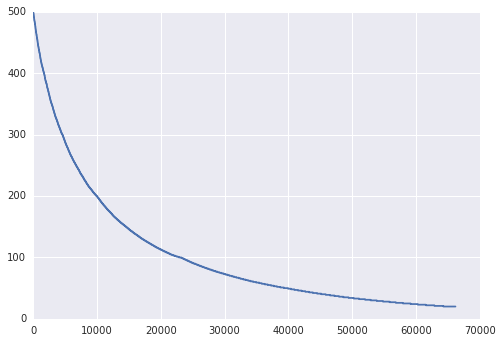

In [15]:
# y-axis=number of ratings by a user who has rated < 500 movies, x-axis=index of array (junk)
_ = plt.plot(user_histo[user_histo < 500].values)

Like in many datasets, there is a long tail of users who have rated less than 100 movies. 

# Movie popularity

In [16]:
movie_histo = raw['movieid'].value_counts()
movie_histo

296      34864
356      34457
593      33668
480      32631
318      31126
110      29154
457      28951
589      28948
260      28566
150      27035
592      26996
1        26449
780      26042
590      25912
527      25777
380      25381
1210     25098
32       24397
50       24037
608      23794
377      23748
588      23531
2571     23229
1196     23091
47       22521
2858     22120
1198     21803
1270     21247
648      21085
344      21014
         ...  
61862        1
59680        1
61913        1
63806        1
61948        1
61970        1
63688        1
3583         1
63662        1
59625        1
58520        1
3561         1
53833        1
60494        1
50477        1
62063        1
64652        1
45707        1
6189         1
55324        1
48374        1
58595        1
4820         1
5565         1
33140        1
64754        1
62237        1
7452         1
6085         1
27740        1
Name: movieid, dtype: int64

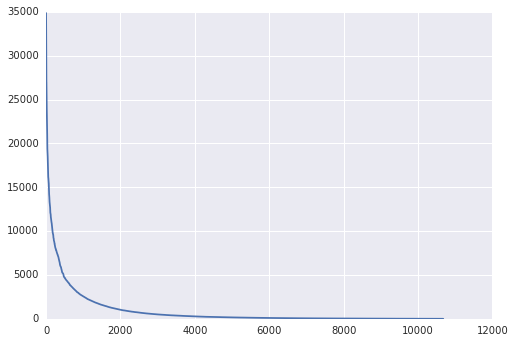

In [17]:
_ = plt.plot(movie_histo.values)

Unlike users who have rated a very high number of movies, there might be less concern for movies that have been rated by many people. 

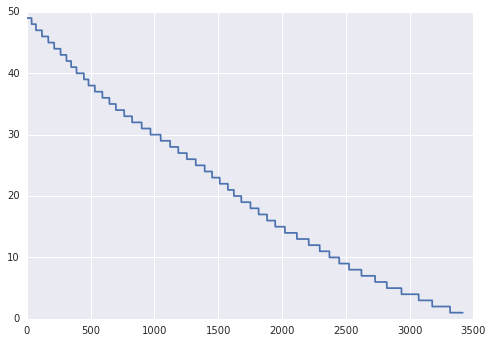

In [18]:
_ = plt.plot(movie_histo[movie_histo < 50].values)


The last plot shows about 3500 movies with less than 50 ratings. Again, we have a choice to make: should our model produce ratings for movies that have very low number of ratings? If we use an embedding model in 50 dimensions, what does it mean to embed a movie into a space with more dimensions than sample points we have for it? For this datalab, we will keep it simple and include these movies, but these questions should be considered in a real system. 